# Proyecto "image denoising"

Carlos

In [31]:
#NumPy: numerical scientific computing 
import numpy as np

#Scikit-learn: machine learning
from sklearn.decomposition import PCA, KernelPCA

#Matplotlib: plotting 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

#SciPy: scientific tools
import scipy.io.matlab as matlab

#OpenCV: computer vision
import cv2


# Carga de los datos

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True, parser='auto')
X = MinMaxScaler().fit_transform(X)

Dividimos en train y test e introducimos ruido a las imágenes.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, train_size=1_000, test_size=100
)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train + noise

# Representación de las imágenes

In [4]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

    

In [27]:
def plot_parallel(X_clean, X_noisy, title_clean, title_noisy):
    """Small helper function to plot 100 digits."""
    # Creamos una figura más ancha para acomodar ambos conjuntos de datos
    fig, axs = plt.subplots(nrows=10, ncols=20, figsize=(16, 8)) 

    # Título y posición central para datos limpios
    axs[0, 4].set_title(title_clean, fontsize=10)

    # Título y posición central para datos ruidosos
    axs[0, 14].set_title(title_noisy, fontsize=10)

    for i in range(10):
        # Plot clean data
        for j, img in enumerate(X_clean[i*10:(i+1)*10]): # Los primeros 10 subplots para los datos limpios
            ax = axs[i, j]
            ax.imshow(img.reshape((16, 16)), cmap="Greys")
            ax.axis("off")

        # Plot noisy data
        for j, img in enumerate(X_noisy[i*10:(i+1)*10]): # Los siguientes 10 subplots para los datos ruidosos
            ax = axs[i, j+10]
            ax.imshow(img.reshape((16, 16)), cmap="Greys")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
def calcular_mse(limpias, originales=X_train):
    """
    Calcula el Error Cuadrático Medio (MSE) entre las imágenes originales y las limpiadas.

    Args:
    - imagenes_originales: Arreglo numpy de imágenes originales.
    - imagenes_limpias:    Arreglo numpy de imágenes limpiadas.

    Returns:
    - mse: Error Cuadrático Medio.
    """
    num_imagenes = len(originales)
    total_mse = 0.0

    for i in range(num_imagenes):
        mse = np.mean((originales[i] - limpias[i])**2)
        total_mse += mse

    mse = total_mse / num_imagenes
    return mse

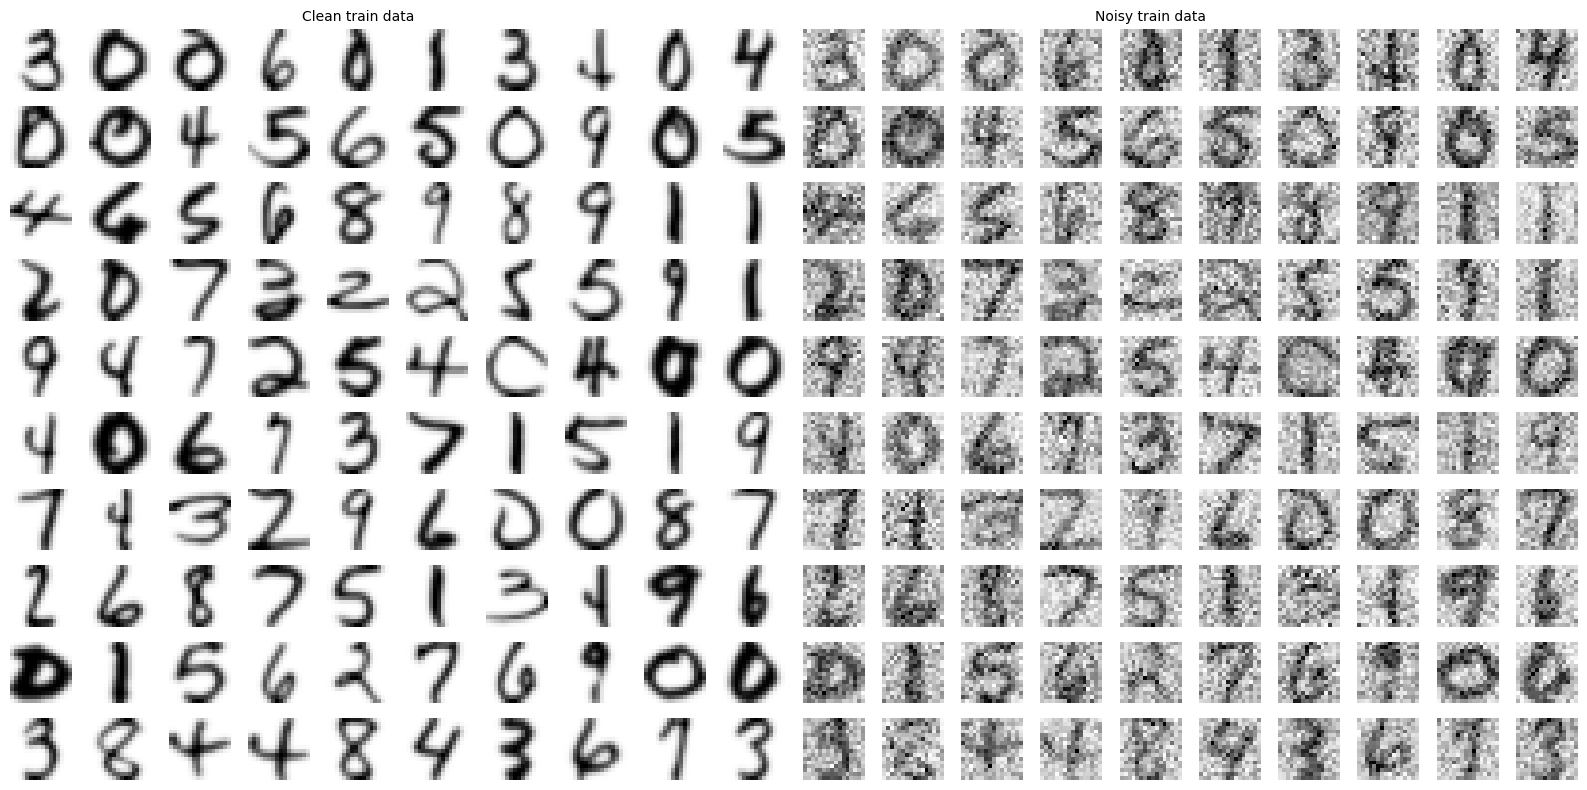

In [25]:
plot_parallel(X_train, X_train_noisy, "Clean train data", "Noisy train data")

# Ejercicio.

### Intenta quitar el ruido de las imágenes de test utilizando los métodos vistos en clase. Cuantifica los resultados cualitativamente y cuantitativamente utilizando MSE. Justifica todas tus respuestas.

Ajustar los hiperparámetros para obtener los mejores resultados posibles (número de componentes, tipo de kernel, gamma ...).

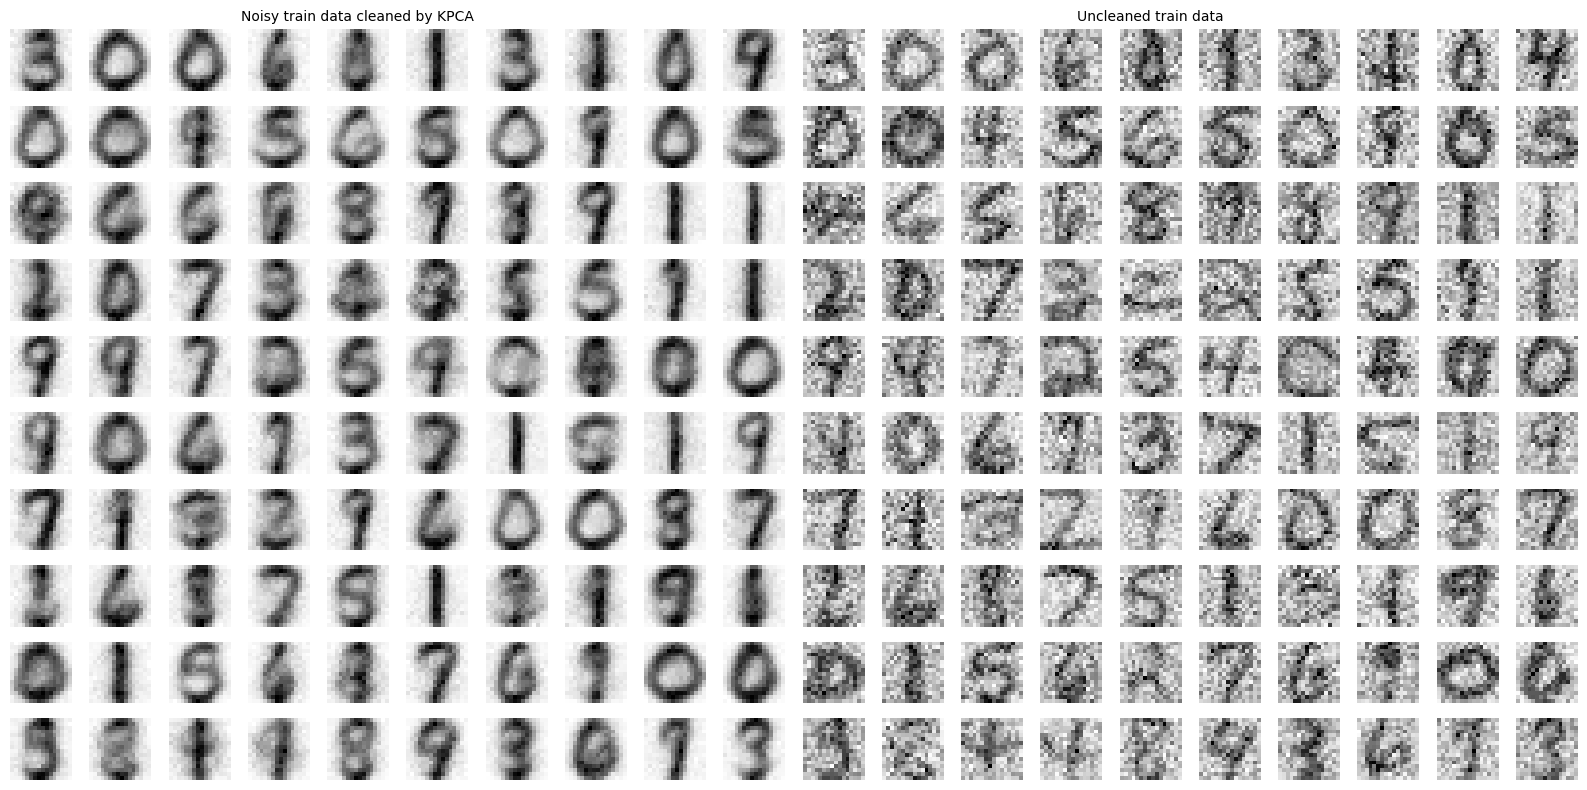

In [111]:
#Transformaciones PCA y KPCA
#X_pca = PCA().fit_transform(X)

kernel="rbf"
gamma = 0.05
degree = 10


kpca = KernelPCA(kernel= kernel, gamma = gamma, degree = degree ,fit_inverse_transform=True).fit(X_train_noisy)
X_kpca = kpca.transform(X_train_noisy)
X_back = kpca.inverse_transform(X_kpca)

plot_parallel(X_back, X_train_noisy, "Noisy train data cleaned by KPCA", "Uncleaned train data")

In [112]:

mse = calcular_mse(limpias=X_back)
print("El MSE originales-limpias:", mse)

mse = calcular_mse(limpias=X_train_noisy)
print("El MSE originales-sucias:", mse)


El MSE originales-limpias: 0.03226449635163708
El MSE originales-sucias: 0.06236631077949732


In [113]:

# Función para aumentar el contraste de una imagen
def increase_contrast(image):
    # Escalar los valores de píxeles al rango [0, 255]
    min_val = np.min(image)
    max_val = np.max(image)
    scaled_image = ((image - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    # Aplicar la ecualización del histograma
    equalized = cv2.equalizeHist(scaled_image)

    return equalized


# Ejemplo de cómo usar la función
# Suponiendo que 'image' es tu imagen de 16x16 píxeles
X_contraste = increase_contrast(X_back)

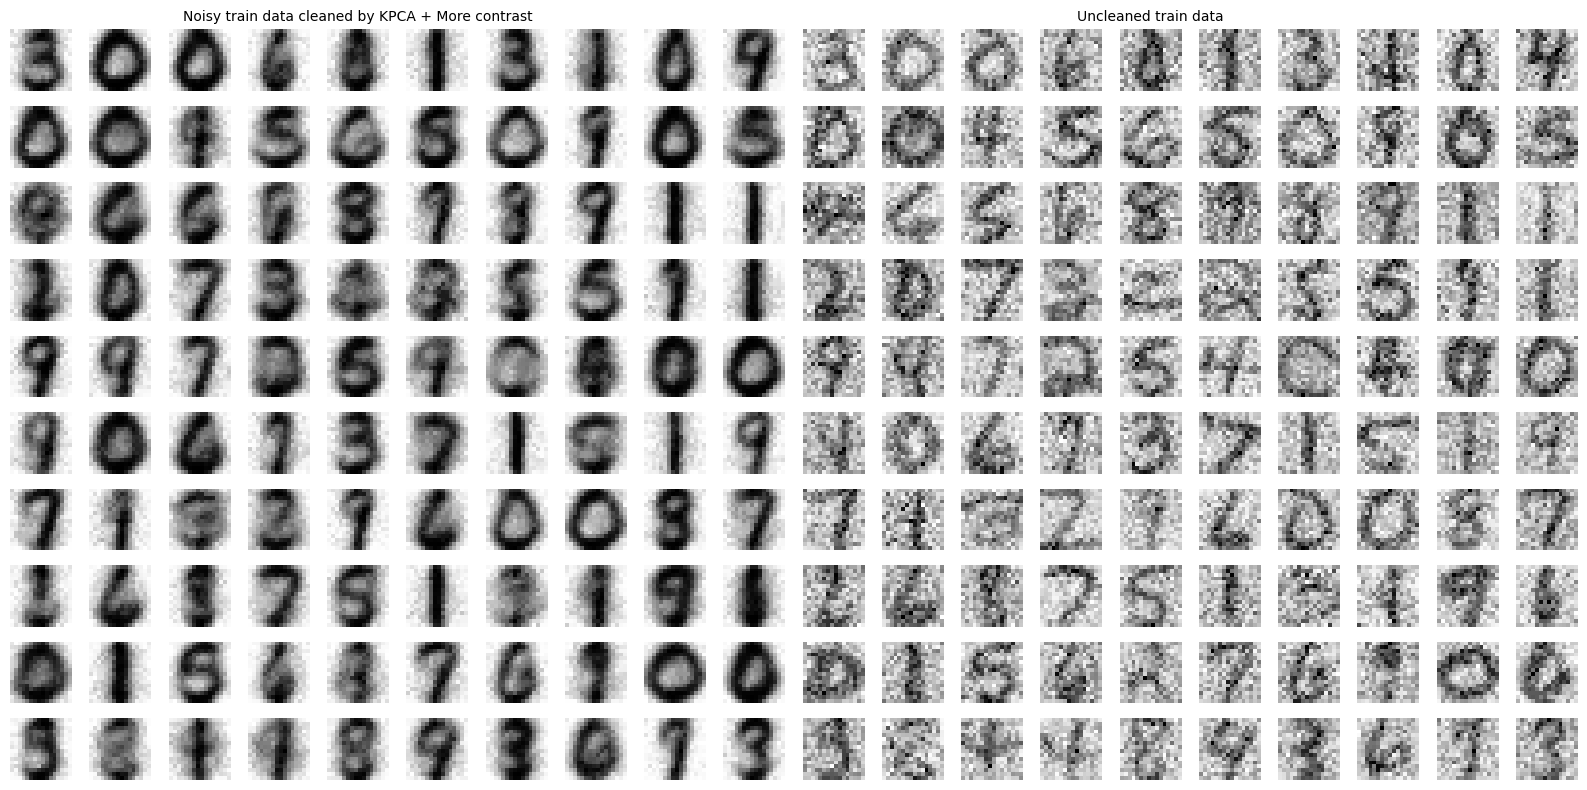

In [114]:
#X_contraste = X_contraste / 255.0
plot_parallel(X_contraste, X_train_noisy, "Noisy train data cleaned by KPCA + More contrast", "Uncleaned train data")

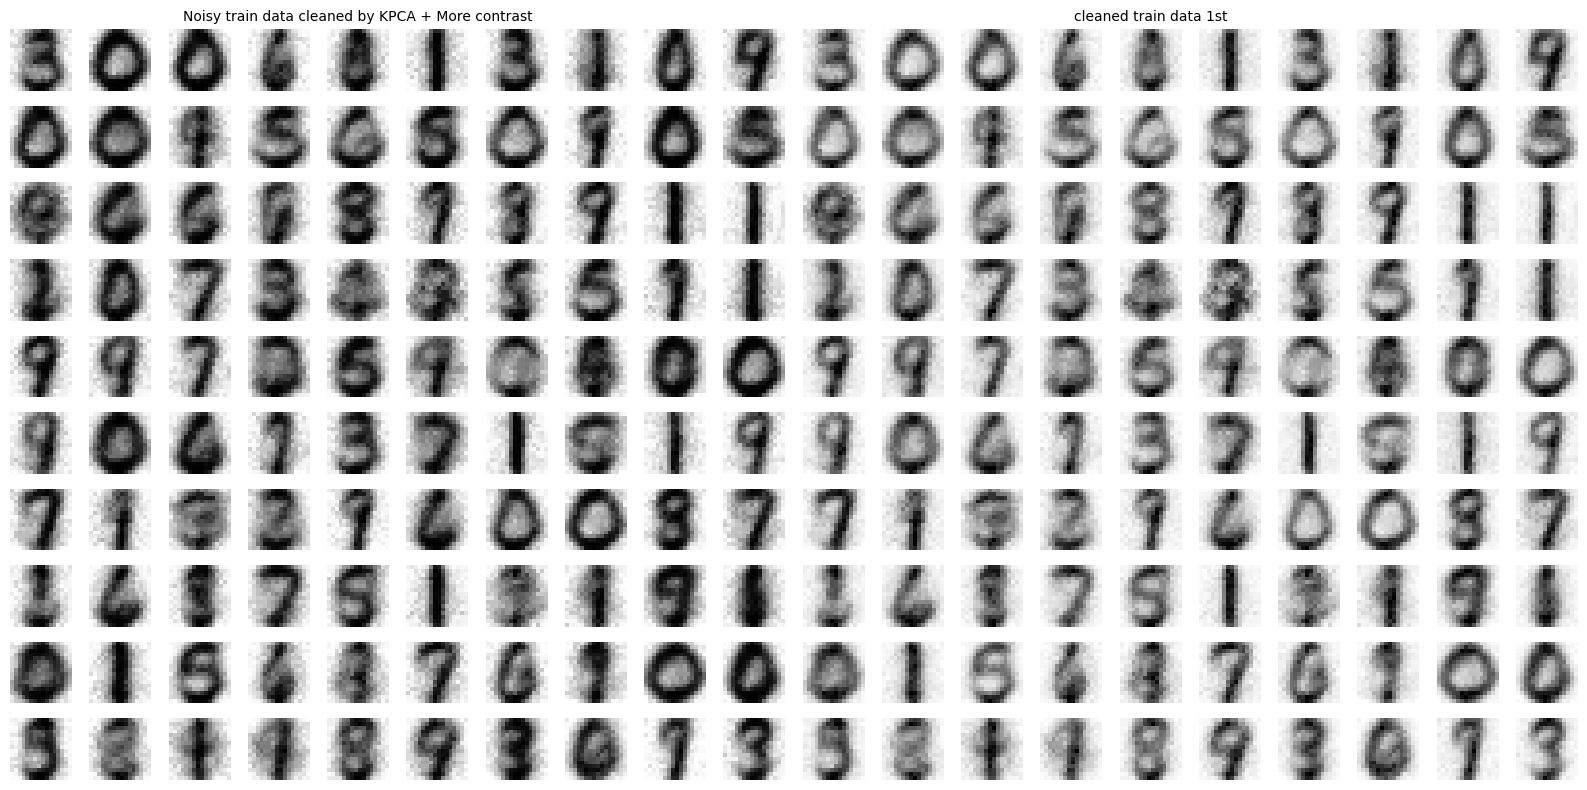

In [107]:
plot_parallel(X_contraste, X_back, "Noisy train data cleaned by KPCA + More contrast", "cleaned train data 1st")

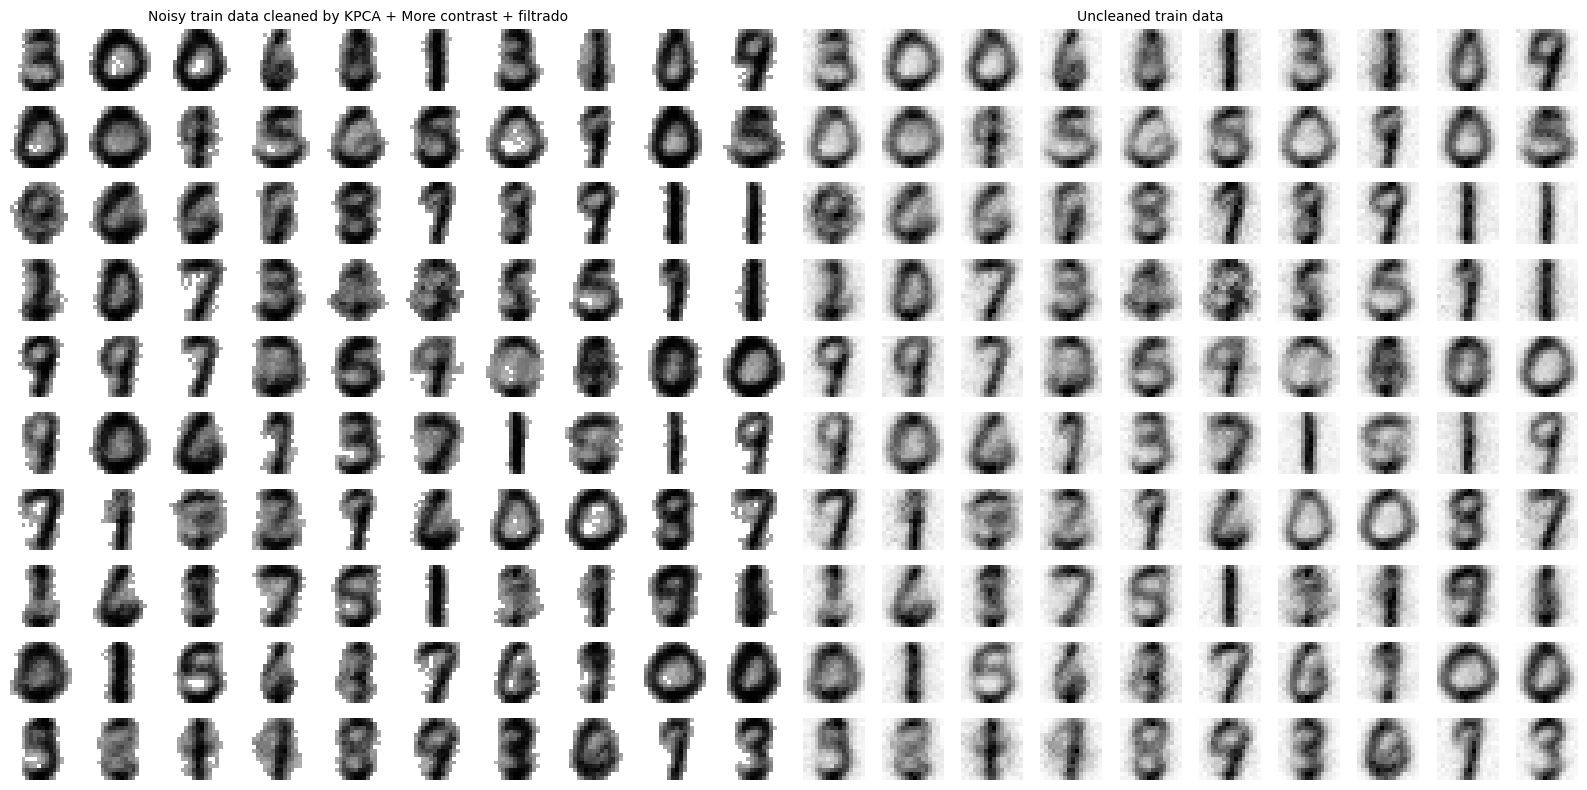

In [115]:
# Calcular el percentil 35 de valor de la imagen
percentil_35 = np.percentile(X_contraste, 40)

# Aplicar una máscara para establecer a 0 los píxeles por debajo del percentil 35
X_contraste_filtrado = np.where(X_contraste < percentil_35, 0, X_contraste)

plot_parallel(X_contraste_filtrado, X_back, "Noisy train data cleaned by KPCA + More contrast + filtrado", "Uncleaned train data")

X_back_2 = X_contraste_filtrado / 255.0

In [124]:
max_value = np.max(X_contraste)

# Calcular el umbral, que es el 60% del máximo valor
umbral = 0.66 * max_value

# Aplicar una máscara para establecer a 0 los píxeles por debajo del umbral
X_contraste_filtrado = np.where(X_contraste < umbral, 0, X_contraste)

X_back_2 = X_contraste_filtrado / 255.0

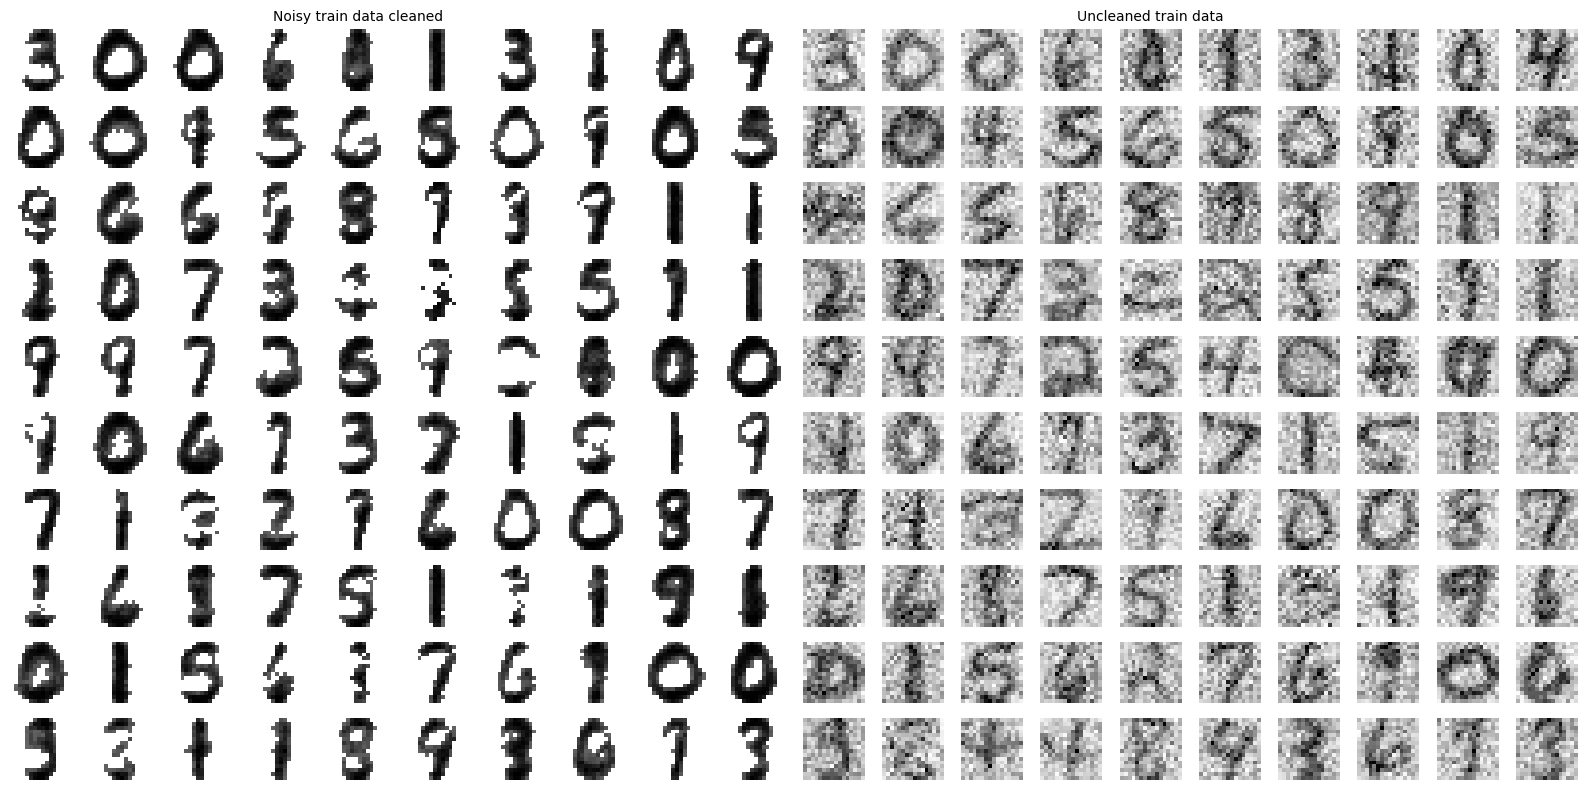

In [136]:
plot_parallel(X_back_2, X_train_noisy, "Noisy train data cleaned", "Uncleaned train data")

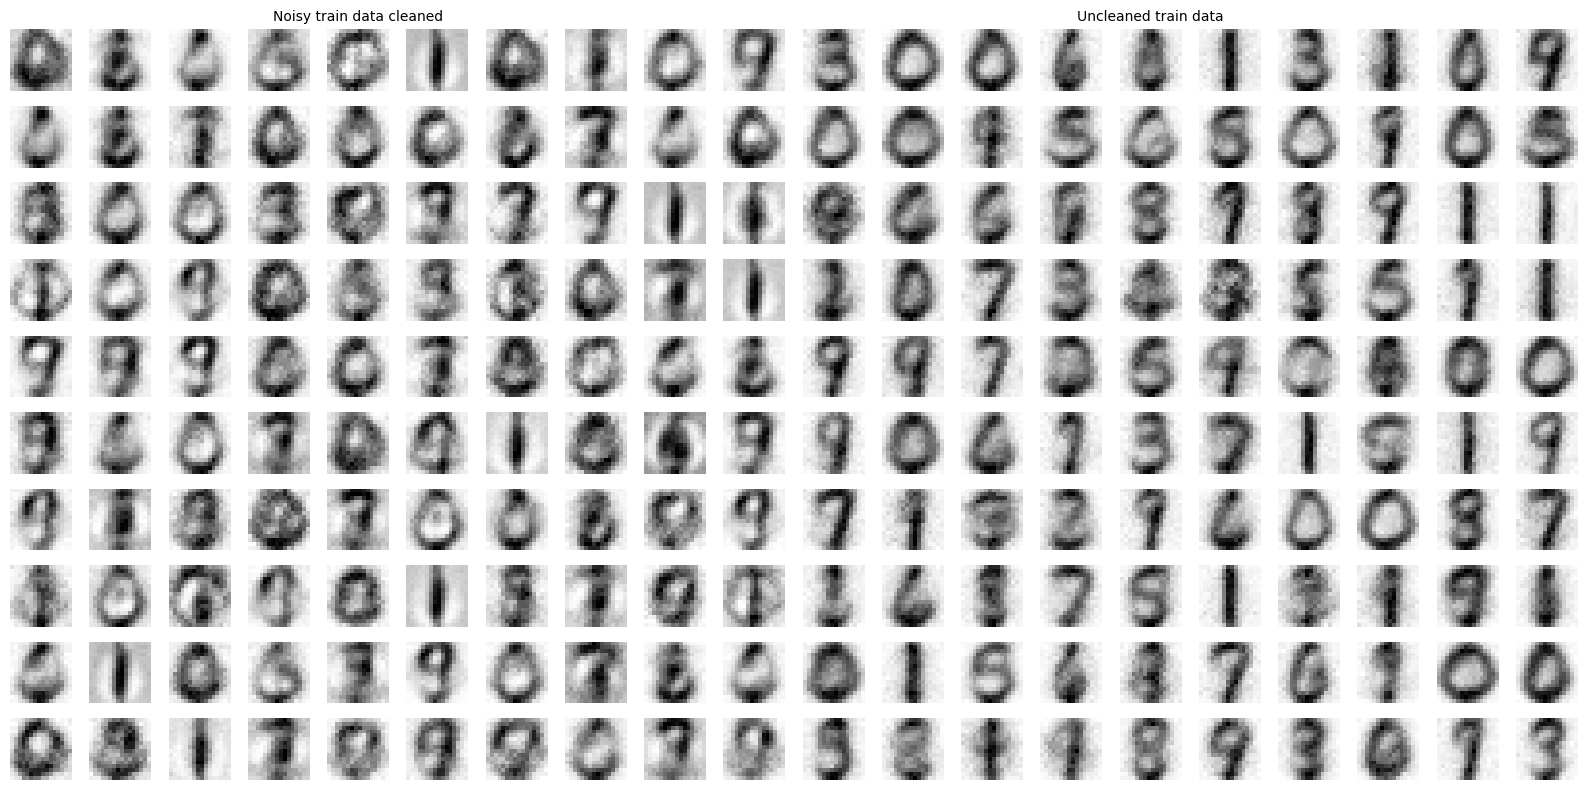

In [133]:


kernel="rbf"
gamma = 0.1
degree = 10

kpca_3 = KernelPCA(kernel= kernel, gamma = gamma, degree = degree ,fit_inverse_transform=True).fit(X_back_2)
X_kpca_3 = kpca_3.transform(X_back_2)
X_back_3 = kpca.inverse_transform(X_kpca_3)

plot_parallel(X_back_3, X_back, "Noisy train data cleaned", "Uncleaned train data")